In [6]:
from os.path import join as opjoin
import numpy as np, pandas as pd

import matplotlib.pyplot as plt
import forestplot as fp

In [3]:
### In addition to the model output, this dataframe includes more descriptive parameter names and groupings
df_lmer_annot = pd.read_csv("/home/tumnic/ahechler/ebits_manuscript/predictionMetabolism/data/lmer_parameters_annotated.csv")
df_lmer_annot.head()

,Parameter,Coefficient,SE,CI,CI_low,CI_high,t,df_error,p,Effects,p_fdr,ParameterLabel,ParameterGroup
0,(Intercept),138.396929,3.767193,0.95,131.013170,145.780687,36.737416,45475,3.450000e-291,fixed,1.000000e-289,Intercept,Intercept
1,networkControl,10.966326,1.513936,0.95,7.998987,13.933665,7.243586,45475,4.440000e-13,fixed,3.220000e-12,network[Control],Network (ref: Visual)
2,networkDefaultMode,8.311806,1.325243,0.95,5.714309,10.909304,6.271911,45475,3.600000e-10,fixed,2.090000e-09,network[DMN],Network (ref: Visual)
3,networkDorsAttn,0.659517,1.555943,0.95,-2.390156,3.709190,0.423870,45475,6.716627e-01,fixed,6.956507e-01,network[DorsAttn],Network (ref: Visual)
4,networkSalVentAttn,-17.524206,1.546647,0.95,-20.555660,-14.492752,-11.330446,45475,1.020000e-29,fixed,1.470000e-28,network[Salience],Network (ref: Visual)


# Formatted model output

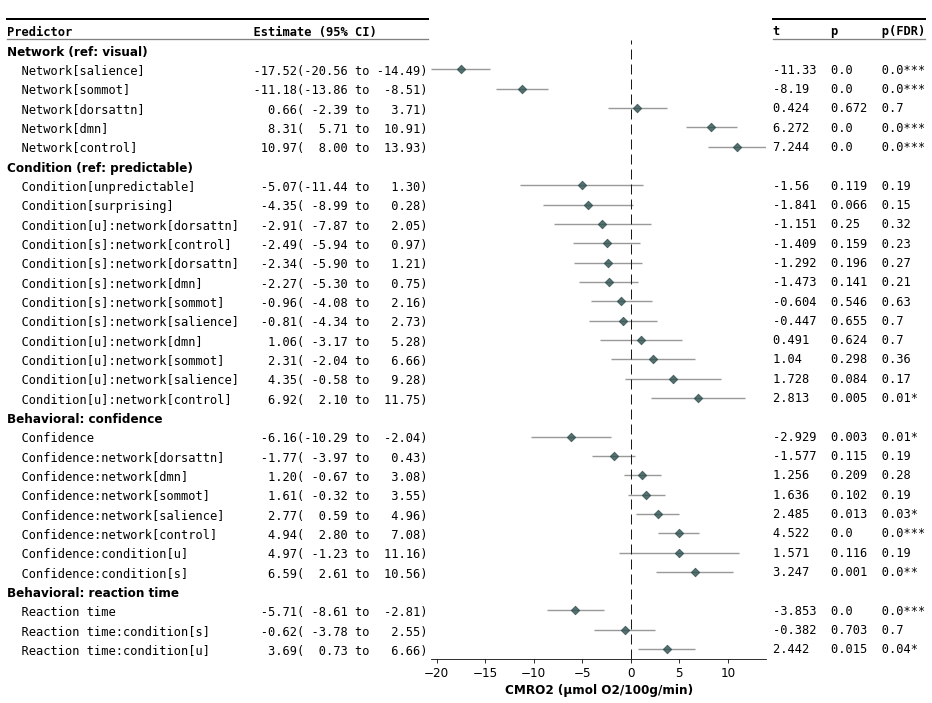

In [5]:
# Drop the intercept to keep the plot readable
df_lmer_annot2 = df_lmer_annot.query("ParameterLabel != 'Intercept'")
# 3 digit precision
df_lmer_annot2 = np.round(df_lmer_annot2, 3)
# Reorder by coefficient values to make plotting more readable
df_lmer_annot2 = df_lmer_annot2.groupby('ParameterGroup', sort=False).apply(lambda x: x.sort_values('Coefficient'))

fp.forestplot(
    # pass the dataframe
    df_lmer_annot2,  
    estimate="Coefficient",  # col containing estimated effect size
    ll="CI_low",
    hl="CI_high",  # lower & higher limits of conf. int.
    ci_report=False,
    varlabel="ParameterLabel",  # column containing the varlabels to be printed on far left
    capitalize="capitalize",  # Capitalize labels
    pval="p_fdr",  # column containing p-values to be formatted
    annote=["est_ci"],  # columns to report on left of plot
    annoteheaders=["Estimate (95% CI)"],  # ^corresponding headers
    rightannote=["t","p","formatted_pval"],  # columns to report on right of plot
    right_annoteheaders=["t","p","p(FDR)"],  # ^corresponding headers
    groupvar="ParameterGroup",  # column containing group labels
    xlabel="CMRO2 (µmol O2/100g/min)",  # x-label title
    xticks=[-20,-15,-10,-5,0,5,10],  # x-ticks to be printed
    table=True,  # Format as a table
    #color_alt_rows=True,
    figsize=(6,12),
    # Additional kwargs for customizations
    **{
        "variable_header":'Predictor',
        "thresholds":(0.001,0.01,0.05), # thresholds for star notation
        "marker": "D",  # set maker symbol as diamond
        "markersize": 35,  # adjust marker size
        "xlinestyle": (0, (10, 5)),  # long dash for x-reference line
        "xlinecolor": ".1",  # gray color for x-reference line
        "xtick_size": 12,  # adjust x-ticker fontsize
    },
)

# Note that the figure used in the paper has slight visual adapations to the marker diamonds to make it more readable.

# Cortical CMRO2 calculations

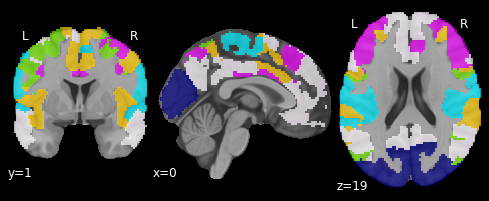

In [7]:
from nilearn import image as nil, plotting as nip
from templateflow import api as tflow

# Get a T1 for visualization
mni_t1 = str(tflow.get('MNI152NLin2009cAsym', resolution=1, desc='brain', suffix='T1w'))
### Load the Schaefer atlas we used: 400 parcels, 7 networks
schaefer_atlas = nil.load_img("../data/tpl-MNI152NLin2009cAsym_res-02_atlas-Schaefer2018_desc-7Networks_dseg.nii.gz")
# We don't have reliable data on the limbic system due to high signal dropout in frontopolar and temporo-polar regions
atlas_sixNetworks = nil.math_img('np.where(img == 7,0,img)', img=schaefer_atlas)
nip.plot_roi(atlas_sixNetworks, bg_img=mni_t1, draw_cross=False)

In [18]:
### Approximate the grey matter mass per network
# Make the simplifying assumption that voxels assigned to networks are 100% grey matter

yeo_nw_data = atlas_sixNetworks.get_fdata()

df_nw_vox = pd.DataFrame(columns=['network','voxels'])
for nw in range(1,7):
    voxels = np.sum(yeo_nw_data == nw)
    df_nw_vox.loc[len(df_nw_vox)] = [nw, voxels]

# 0.00832g of grey matter per GM voxel in 2mm³ space
df_nw_vox['mass'] = df_nw_vox['voxels'] * 0.00832
# get network names
df_nw_vox = df_nw_vox.replace({'network':{1:'Visual',2:'SomatoMotor',3:'DorsalAtt',4:'Salience',5:'Control',6:'DefaultMode'}})

df_nw_vox

,network,voxels,mass
0,Visual,23444,195.05408
1,SomatoMotor,19937,165.87584
2,DorsalAtt,15119,125.79008
3,Salience,14697,122.27904
4,Control,19789,164.64448
5,DefaultMode,34498,287.02336


In [20]:
### Get the predicted CMRO2 per network and scale to their grey matter mass

# Set an index for easier extraction of coefficient estimates
df_lmer_annot = df_lmer_annot.set_index('Parameter')

### Calcute mass-adjusted CMRO2
coef_intercept = df_lmer_annot.loc['(Intercept)','Coefficient']
# The visual network is the reference, so we assign a value of 0. The same goes for the non-significant coefficient of the Dorsal Attention network
coefs_networks = [0, # Visual
                df_lmer_annot.loc['networkSomatoMotor','Coefficient'],
                0, # DorsAttn
                df_lmer_annot.loc['networkSalVentAttn','Coefficient'],
                df_lmer_annot.loc['networkControl','Coefficient'],
                df_lmer_annot.loc['networkDefaultMode','Coefficient']]
# Predicted network-wise CMRO2 is the combination of the intercept (representing the visual network during predictable input) and the network coefficients
cmro2_avg = [coef_intercept + coef for coef in coefs_networks]
df_nw_vox['cmro2_avg'] = cmro2_avg
# Scale CMRO2 up to grey matter mass, resulting in the simplified unit of µmol O2/min
df_nw_vox['cmro2_massadj'] = df_nw_vox['cmro2_avg'] * (df_nw_vox['mass']/100)

In [21]:
def calc_confidence_savings(df_networks, df_model, coef_column):
    '''Extends the dataframe with network-wise energy savings for high confidence relative to low confidence observers.'''

    ### Add model parameters for the confidence:network interaction
    # Networks with a non-significant interaction get the reference effect assigned
    df_networks['conf_cmro2'] = [df_model.loc['confidence_z',coef_column], # Visual
                            df_model.loc['confidence_z',coef_column], # SomatoMotor
                            df_model.loc['confidence_z',coef_column], # Dorsal Attention
                            df_model.loc['confidence_z',coef_column] + df_model.loc['confidence_z:networkSalVentAttn', 'Coefficient'], # Salience: Simple slopes indicated p<0.05 for combined effect
                            df_model.loc['confidence_z',coef_column] + df_model.loc['confidence_z:networkControl', 'Coefficient'], # Control: Simple slopes indicated p<0.05 for combined effect
                            df_model.loc['confidence_z',coef_column]] # Default Mode
    df_networks['conf_cmro2_adj'] = df_networks['conf_cmro2'] * (df_networks['mass']/100)

    ### Calculate predicted cost for low and high confidence
    df_networks['cmro2_lowConf_adj'] = df_networks['cmro2_massadj'] + (df_networks['conf_cmro2_adj']*(-1.96)) # low confidence: 5th percentile; z-value of -1.96
    df_networks['cmro2_highConf_adj'] = df_networks['cmro2_massadj'] + (df_networks['conf_cmro2_adj']*(1.96)) # high confidence: 95th percentile; z-value of 1.96

    ### Calculate absolute difference and relative saving for high confidence
    df_networks['Conf_saving_percent'] = ((df_networks['cmro2_highConf_adj'] - df_networks['cmro2_lowConf_adj']) / df_networks['cmro2_lowConf_adj'])  * 100

    return df_networks

In [22]:
print('Estimated energy savings:')
df_savings = calc_confidence_savings(df_nw_vox.copy(), df_lmer_annot, 'Coefficient')
display(df_savings)
print('95% CI: lower')
df_savings_lowCI = calc_confidence_savings(df_nw_vox.copy(), df_lmer_annot, 'CI_low')
display(df_savings_lowCI)
print('95% CI: higher')
df_savings_highCI = calc_confidence_savings(df_nw_vox.copy(), df_lmer_annot, 'CI_high')
display(df_savings_highCI)

Estimated energy savings:


,network,voxels,mass,cmro2_avg,cmro2_massadj,conf_cmro2,conf_cmro2_adj,cmro2_lowConf_adj,cmro2_highConf_adj,Conf_saving_percent
0,Visual,23444,195.05408,138.396929,269.948856,-6.162564,-12.020332,293.508706,246.389006,-16.053936
1,SomatoMotor,19937,165.87584,127.212886,211.015444,-6.162564,-10.222204,231.050963,190.979924,-17.342944
2,DorsalAtt,15119,125.79008,138.396929,174.089607,-6.162564,-7.751894,189.283319,158.895896,-16.053936
3,Salience,14697,122.27904,120.872722,147.802004,-3.387384,-4.142061,155.920444,139.683564,-10.413567
4,Control,19789,164.64448,149.363255,245.918354,-1.225136,-2.017119,249.871907,241.964800,-3.164464
5,DefaultMode,34498,287.02336,146.708735,421.088340,-6.162564,-17.687997,455.756814,386.419866,-15.213584


95% CI: lower


,network,voxels,mass,cmro2_avg,cmro2_massadj,conf_cmro2,conf_cmro2_adj,cmro2_lowConf_adj,cmro2_highConf_adj,Conf_saving_percent
0,Visual,23444,195.05408,138.396929,269.948856,-10.286406,-20.064055,309.274404,230.623307,-25.430846
1,SomatoMotor,19937,165.87584,127.212886,211.015444,-10.286406,-17.062663,244.458263,177.572624,-27.360760
2,DorsalAtt,15119,125.79008,138.396929,174.089607,-10.286406,-12.939279,199.450594,148.728621,-25.430846
3,Salience,14697,122.27904,120.872722,147.802004,-7.511227,-9.184657,165.803931,129.800077,-21.714717
4,Control,19789,164.64448,149.363255,245.918354,-5.348979,-8.806799,263.179679,228.657028,-13.117521
5,DefaultMode,34498,287.02336,146.708735,421.088340,-10.286406,-29.524389,478.956143,363.220537,-24.164134


95% CI: higher


,network,voxels,mass,cmro2_avg,cmro2_massadj,conf_cmro2,conf_cmro2_adj,cmro2_lowConf_adj,cmro2_highConf_adj,Conf_saving_percent
0,Visual,23444,195.05408,138.396929,269.948856,-2.038721,-3.976608,277.743007,262.154705,-5.612491
1,SomatoMotor,19937,165.87584,127.212886,211.015444,-2.038721,-3.381745,217.643664,204.387223,-6.090892
2,DorsalAtt,15119,125.79008,138.396929,174.089607,-2.038721,-2.564508,179.116044,169.063171,-5.612491
3,Salience,14697,122.27904,120.872722,147.802004,0.736458,0.900534,146.036957,149.567052,2.417261
4,Control,19789,164.64448,149.363255,245.918354,2.898707,4.772561,236.564135,255.272573,7.908400
5,DefaultMode,34498,287.02336,146.708735,421.088340,-2.038721,-5.851605,432.557485,409.619196,-5.302946


## Polar bar plot

In [14]:
from plotly.express import bar_polar
import plotly.graph_objects as go

In [23]:
### Reformat the previously created dataframe for plotting
df_plot = df_savings[['network','cmro2_massadj','cmro2_lowConf_adj','cmro2_highConf_adj']]

# Instead of absolute cost, calculate differences in cost that can be plotted as stacked bars
df_plot['cmro2_lowConf_adj'] = df_plot['cmro2_lowConf_adj'] - df_plot['cmro2_massadj']
df_plot['cmro2_massadj'] = df_plot['cmro2_massadj'] - df_plot['cmro2_highConf_adj']

df_plot = df_plot.melt(id_vars=['network'])
df_plot = df_plot.rename(columns={'variable':'confidence', 'value':'CMRO2'})
# padding category levels because legend gets cut when saving figure
df_plot = df_plot.replace({'confidence':{'cmro2_massadj':'average   ', 'cmro2_lowConf_adj':'low confidence   ', 'cmro2_highConf_adj':'high confidence   '}})
df_plot

,network,confidence,CMRO2
0,Visual,average,23.559850
1,SomatoMotor,average,20.035520
2,DorsalAtt,average,15.193711
3,Salience,average,8.118440
4,Control,average,3.953553
5,DefaultMode,average,34.668474
6,Visual,low confidence,23.559850
7,SomatoMotor,low confidence,20.035520
8,DorsalAtt,low confidence,15.193711
9,Salience,low confidence,8.118440


In [25]:
fig = bar_polar(df_plot, r="CMRO2", theta="network", color="confidence",
                   category_orders={'confidence':['high confidence   ','average   ','low confidence   '], 'network':['DefaultMode','Visual','Control','SomatoMotor','DorsalAtt','Salience']},
                   color_discrete_map={'high confidence   ':'navajowhite', 'average   ':'sandybrown','low confidence   ':'darkorange'},
                   width=900, height=600)

fig.update_layout(font_size=25, margin={'t':100, 'b':100, 'l':100})
fig.update_layout(legend_traceorder="reversed")
fig.update_polars(radialaxis_tickfont={'size':18})

fig.show()

# Note that the paper figure has an radial axis title added manually

## Bar plot

In [26]:
def calculate_cost_change(df, sig_network_slopes):
    '''Return the percent change of oxygen consumption across all networks between high confidence and low confidence subjects'''

    cmro2_lowConf = np.array([row['cmro2_lowConf_adj'] if row['network'] in (sig_network_slopes) else row['cmro2_massadj'] for ind, row in df.iterrows()]).sum()
    cmro2_highConf = np.array([row['cmro2_highConf_adj'] if row['network'] in (sig_network_slopes) else row['cmro2_massadj'] for ind, row in df.iterrows()]).sum()

    return ((cmro2_highConf - cmro2_lowConf) / cmro2_lowConf) * 100


In [29]:
### Only include changes for networks with a reliable effect of confidence based on simple slope analyses
sig_network_slopes = ['Visual','SomatoMotor','DorsalAtt','DefaultMode']

saving_upperCI = calculate_cost_change(df_savings_highCI, sig_network_slopes)
saving_avg = calculate_cost_change(df_savings, sig_network_slopes)
saving_lowerCI = calculate_cost_change(df_savings_lowCI, sig_network_slopes)

ci = saving_upperCI - saving_avg

print(f'Cortical cost saving: {saving_avg.round(2)} [95% CI: [{saving_upperCI.round(2)}, {saving_lowerCI.round(2)}]]')

Cortical cost saving: -11.96 [95% CI: [-4.12, -19.19]]


In [32]:
cat=['Cortex']

fig = go.Figure([go.Bar(x=cat, y=[100+saving_avg], marker_color='navajowhite', name='High confidence          '),
                 go.Bar(x=cat, y=[abs(saving_avg)], marker_color='darkorange', name='Low confidence          '),
                 go.Scatter(x=cat, y=[100+saving_avg], marker_color='black', marker_size=15, error_y=dict(type='data', array=[ci], thickness=2, width=8), showlegend=False)
                 ])

fig.update_yaxes(title='Energy consumption (%)')
fig.update_layout(width=500, height=600, barmode='stack', template='plotly_white',
                  font=dict(size=20))
fig.show()

# Opposing effects of confidence and RT

In [58]:
from pingouin import corr

In [59]:
### For every SD that confidence increases, RT decreases by 0.36 SDs
    # I.e. participants get quicker (lower RT) when they are confident
    # Since CMRO2 increases for quicker reactions: Roughly a third of the energy saved with increasing confidence is offset by RT
corr(df_data.query("condition != 'predictable'").drop_duplicates('subject')['confidence_z'],
    df_data.query("condition != 'predictable'").drop_duplicates('subject')['reaction_time_z'])

,n,r,CI95%,p-val,BF10,power
pearson,41,-0.358135,"[-0.6, -0.06]",0.021498,2.499,0.645971
